In [154]:
import torch
import cv2
import numpy as np
from PIL import Image
from IPython.display import display
from torchvision import transforms

In [ ]:
model = torch.hub.load("hustvl/yolop", "yolop", pretrained=True)
model.eval()

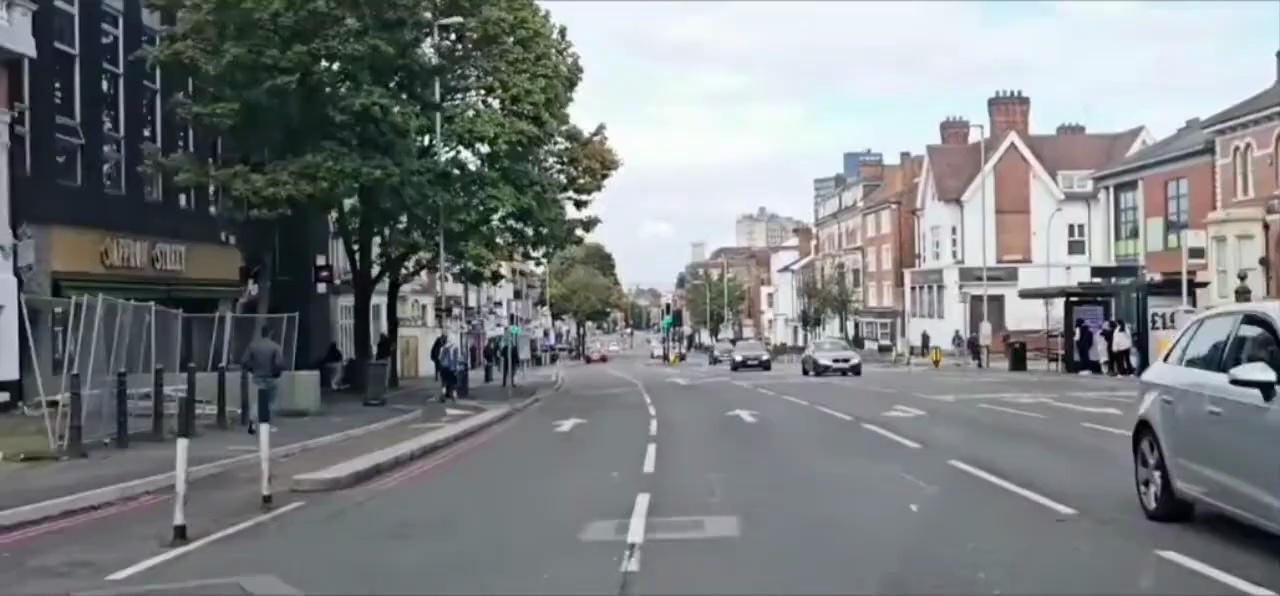

In [156]:
image_path = "frame.jpg"
img = Image.open(image_path)
display(img)

In [157]:
t = transforms.ToTensor()
feature = t(img)
feature.shape

torch.Size([3, 596, 1280])

In [158]:
tr = transforms.Resize((640, 640))
feature = tr(feature)
feature.shape

torch.Size([3, 640, 640])

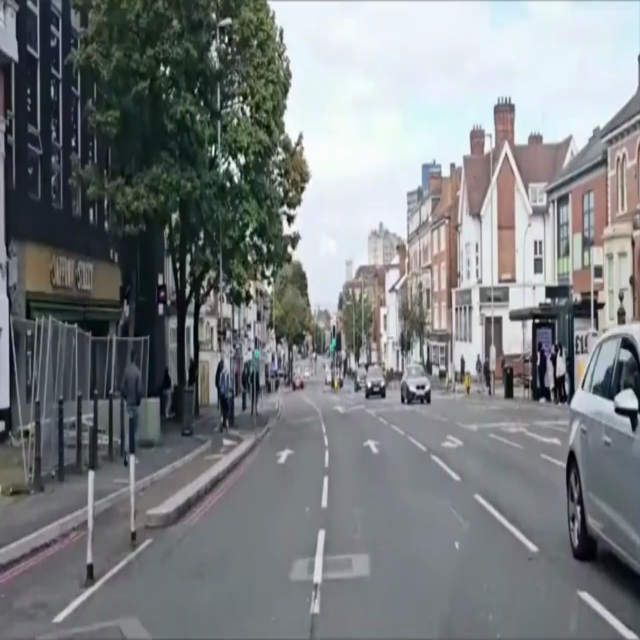

In [159]:
ti = transforms.ToPILImage()
display(ti(feature))

In [160]:
feature = feature.unsqueeze(0)
feature.shape

torch.Size([1, 3, 640, 640])

In [161]:
det_out, da_seg_out, ll_seg_out = model(feature)
ll_seg_out.shape

torch.Size([1, 2, 640, 640])

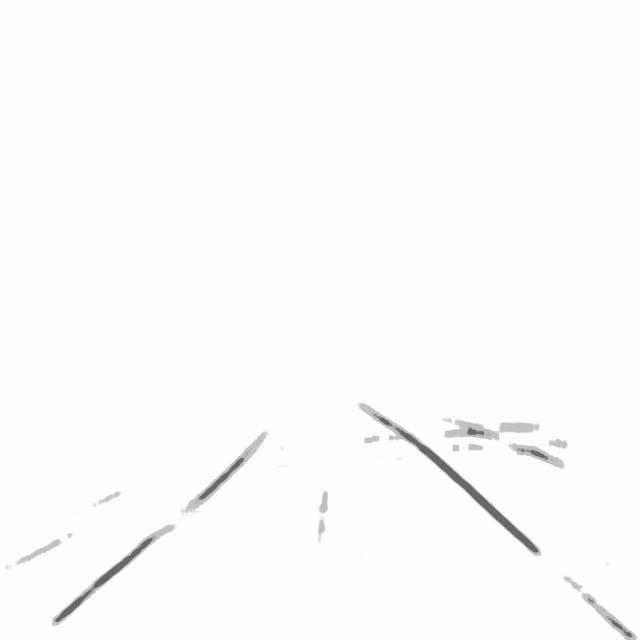

In [162]:
display(ti(ll_seg_out.squeeze()))

In [163]:
original_height, original_width = img.size
tro = transforms.Resize((original_width, original_height))
ll_seg_resized = tro(ll_seg_out)
ll_seg_resized.shape

torch.Size([1, 2, 596, 1280])

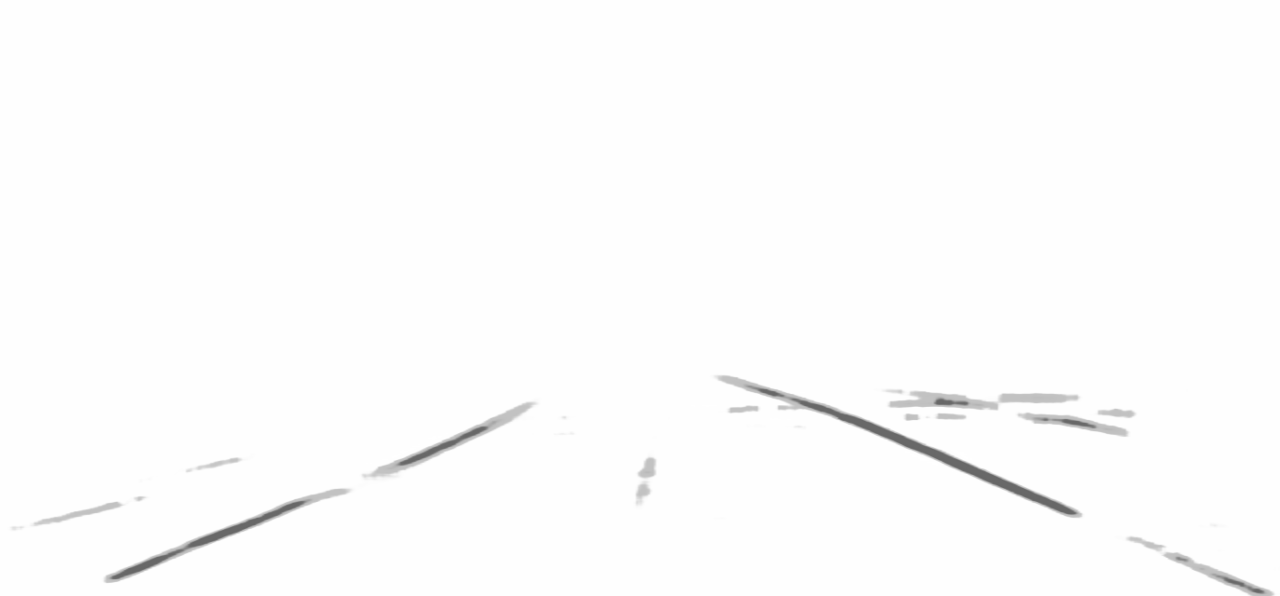

In [164]:
display(ti(ll_seg_resized.squeeze()))

In [165]:
# Extract the image data and convert to float if necessary
extract = ll_seg_resized[0, 0, :, :].float()

# Create a mask for dark pixels
mask = extract < 0.9

# Create an RGB image initialized with the grayscale image
rgb_image = torch.stack([extract, extract, extract], dim=0)  # Shape: [3, height, width]

# Fill dark pixels with green
rgb_image[1, mask] = 1.0  # Set green channel to 1.0 (full green)
rgb_image[0, mask] = 0.0 # Set red channel to 0.0
rgb_image[2, mask] = 0.0 # Set blue channel to 0.0
rgb_image.shape

torch.Size([3, 596, 1280])

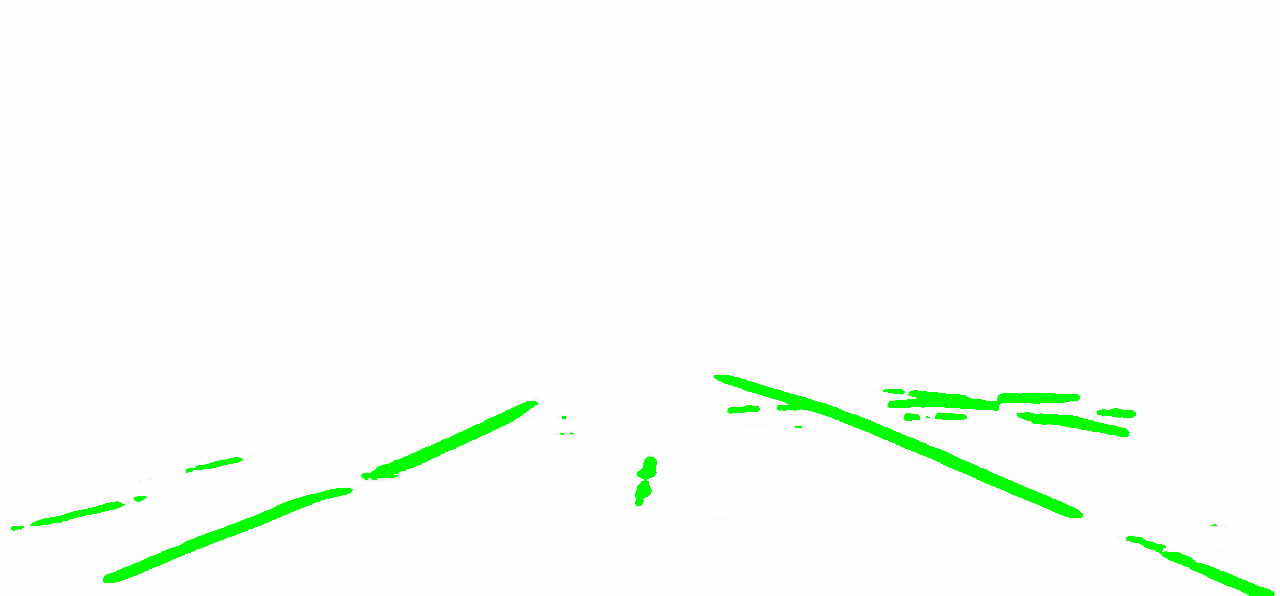

In [166]:
display(ti(rgb_image))

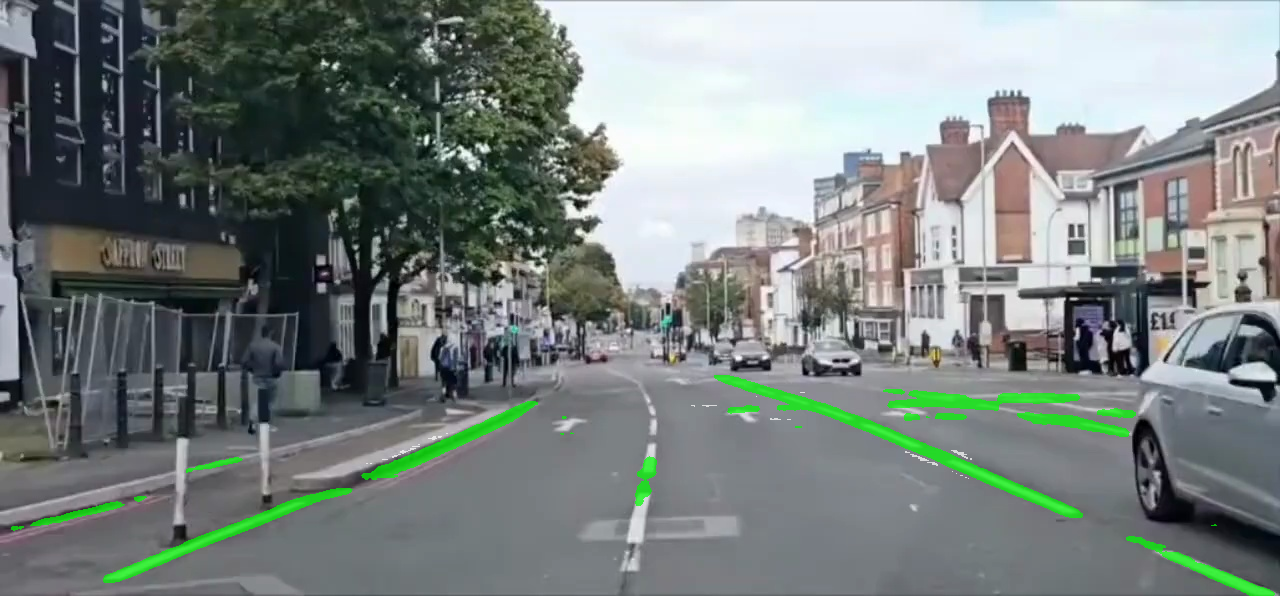

In [167]:
background = img.convert("RGBA")
foreground = ti(rgb_image).convert("RGBA")

# make foreground transparent
datas = foreground.getdata()
new_data = []
for item in datas:
    if item[1] != 255:
        new_data.append((255, 255, 255, 0))
    else:
        new_data.append(item)
foreground.putdata(new_data)

combined = background.copy()
position = (0, 0)
alpha = 0.7
combined.paste(foreground, position, foreground if alpha == 1.0 else foreground.convert("RGBA"))
if alpha < 1.0:
    combined = Image.blend(background, combined, alpha)

display(combined)